In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import category_encoders as ce

import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential


from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./data/ship_clean.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   type                      180519 non-null  object 
 1   actual_ship_days          180519 non-null  int64  
 2   estimated_ship_days       180519 non-null  int64  
 3   delivery_status           180519 non-null  object 
 4   late_delivery_risk        180519 non-null  int64  
 5   category_id               180519 non-null  int64  
 6   category_name             180519 non-null  object 
 7   customer_city             180519 non-null  object 
 8   customer_id               180519 non-null  int64  
 9   customer_segment          180519 non-null  object 
 10  customer_state            180519 non-null  object 
 11  customer_zipcode          180516 non-null  float64
 12  department_name           180519 non-null  object 
 13  latitude                  180519 non-null  f

In [4]:
df.columns

Index(['type', 'actual_ship_days', 'estimated_ship_days', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_id', 'customer_segment', 'customer_state', 'customer_zipcode',
       'department_name', 'latitude', 'longitude', 'market', 'order_city',
       'order_country', 'order_date', 'order_id', 'order_item_discount_rate',
       'order_item_profit_ratio', 'order_item_quantity', 'order_region',
       'order_state', 'order_status', 'product_card_id', 'product_name',
       'product_price', 'shipping_date', 'shipping_mode', 'ship_performance',
       'ontime', 'is_fraud', 'order_hour', 'order_before_noon'],
      dtype='object')

In [5]:
# change order_date and shipping_date features to datetime format-

df['order_date'] = pd.to_datetime(df['order_date'])

In [6]:
df['shipping_date'] = pd.to_datetime(df['shipping_date'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   type                      180519 non-null  object        
 1   actual_ship_days          180519 non-null  int64         
 2   estimated_ship_days       180519 non-null  int64         
 3   delivery_status           180519 non-null  object        
 4   late_delivery_risk        180519 non-null  int64         
 5   category_id               180519 non-null  int64         
 6   category_name             180519 non-null  object        
 7   customer_city             180519 non-null  object        
 8   customer_id               180519 non-null  int64         
 9   customer_segment          180519 non-null  object        
 10  customer_state            180519 non-null  object        
 11  customer_zipcode          180516 non-null  float64       
 12  de

In [8]:
# check categorical column value counts to figure out which can be onehotencoded-

df['type'].unique()  # ohe

array(['DEBIT', 'TRANSFER', 'CASH', 'PAYMENT'], dtype=object)

In [9]:
df['delivery_status'].unique()    # drop, colinear with prediction column

array(['Advance shipping', 'Late delivery', 'Shipping on time',
       'Shipping canceled'], dtype=object)

In [10]:
# df['category_name'].unique()    # too many vals

In [11]:
# df['customer_city'].unique()    # too many vals

In [12]:
df['customer_segment'].unique()   # ohe

array(['Consumer', 'Home Office', 'Corporate'], dtype=object)

In [13]:
# df['customer_state'].unique()   # too many vals

In [14]:
df['department_name'].unique()    # ohe

array(['Fitness', 'Apparel', 'Golf', 'Footwear', 'Outdoors', 'Fan Shop',
       'Technology', 'Book Shop', 'Discs Shop', 'Pet Shop',
       'Health and Beauty '], dtype=object)

In [15]:
df['market'].unique() # can ohe

array(['Pacific Asia', 'USCA', 'Africa', 'Europe', 'LATAM'], dtype=object)

In [16]:
# df['order_city'].unique()      # too many vals

In [17]:
# df['order_country'].unique()   # too many vals

In [18]:
df['order_region'].unique()      # ohe

array(['Southeast Asia', 'South Asia', 'Oceania', 'Eastern Asia',
       'West Asia', 'West of USA ', 'US Center ', 'West Africa',
       'Central Africa', 'North Africa', 'Western Europe',
       'Northern Europe', 'Central America', 'Caribbean', 'South America',
       'East Africa', 'Southern Europe', 'East of USA', 'Canada',
       'Southern Africa', 'Central Asia', 'Eastern Europe',
       'South of  USA '], dtype=object)

In [19]:
# df['order_state'].unique()   # too many vals

In [20]:
df['order_status'].unique()    # ohe

array(['COMPLETE', 'PENDING', 'CLOSED', 'PENDING_PAYMENT', 'CANCELED',
       'PROCESSING', 'SUSPECTED_FRAUD', 'ON_HOLD', 'PAYMENT_REVIEW'],
      dtype=object)

In [21]:
# df['product_name'].unique()   # too many vals

In [22]:
df['shipping_mode'].unique()    # ohe

array(['Standard Class', 'First Class', 'Second Class', 'Same Day'],
      dtype=object)

In [23]:
# drop the categorical variables with too many values, IDed above-

X = df.drop(columns=['category_name', 'customer_city', 'customer_state', 'order_city', 'order_country', 'order_state', 'product_name'])

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   type                      180519 non-null  object        
 1   actual_ship_days          180519 non-null  int64         
 2   estimated_ship_days       180519 non-null  int64         
 3   delivery_status           180519 non-null  object        
 4   late_delivery_risk        180519 non-null  int64         
 5   category_id               180519 non-null  int64         
 6   customer_id               180519 non-null  int64         
 7   customer_segment          180519 non-null  object        
 8   customer_zipcode          180516 non-null  float64       
 9   department_name           180519 non-null  object        
 10  latitude                  180519 non-null  float64       
 11  longitude                 180519 non-null  float64       
 12  ma

In [25]:
# drop features that overlap with/bias the target (ontime)-

X = X.drop(columns=['actual_ship_days', 'late_delivery_risk', 'delivery_status', 'order_status', 'ship_performance', 'ontime'])

In [26]:
# drop datetime dtypes-

# X = X.drop(columns=['order_date', 'shipping_date'])

In [27]:
# drop shipping_date (keep order_date)-

# X = X.drop(columns=['shipping_date'])

In [28]:
# change order_date from datetime to ordinal so it can be included in X-

# X['order_date'] = X['order_date'].map(dt.datetime.toordinal)

In [29]:
# drop order_date (keep shipping_date)-

X = X.drop(columns=['order_date'])

In [30]:
# change shipping_date from datetime to ordinal so it can be included in X-

X['shipping_date'] = X['shipping_date'].map(dt.datetime.toordinal)

In [31]:
X.shape

(180519, 22)

In [32]:
# drop zipcode, raises an error-

X = X.drop(columns=['customer_zipcode'])

In [33]:
X.shape

(180519, 21)

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   type                      180519 non-null  object 
 1   estimated_ship_days       180519 non-null  int64  
 2   category_id               180519 non-null  int64  
 3   customer_id               180519 non-null  int64  
 4   customer_segment          180519 non-null  object 
 5   department_name           180519 non-null  object 
 6   latitude                  180519 non-null  float64
 7   longitude                 180519 non-null  float64
 8   market                    180519 non-null  object 
 9   order_id                  180519 non-null  int64  
 10  order_item_discount_rate  180519 non-null  float64
 11  order_item_profit_ratio   180519 non-null  float64
 12  order_item_quantity       180519 non-null  int64  
 13  order_region              180519 non-null  o

In [35]:
# set y-

y = df['ontime']

In [36]:
y

0         1
1         0
2         1
3         1
4         1
         ..
180514    1
180515    0
180516    0
180517    1
180518    1
Name: ontime, Length: 180519, dtype: int64

In [37]:
# get a baseline (57%)-

y.value_counts(normalize=True)

0    0.572793
1    0.427207
Name: ontime, dtype: float64

In [38]:
y.shape

(180519,)

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   type                      180519 non-null  object 
 1   estimated_ship_days       180519 non-null  int64  
 2   category_id               180519 non-null  int64  
 3   customer_id               180519 non-null  int64  
 4   customer_segment          180519 non-null  object 
 5   department_name           180519 non-null  object 
 6   latitude                  180519 non-null  float64
 7   longitude                 180519 non-null  float64
 8   market                    180519 non-null  object 
 9   order_id                  180519 non-null  int64  
 10  order_item_discount_rate  180519 non-null  float64
 11  order_item_profit_ratio   180519 non-null  float64
 12  order_item_quantity       180519 non-null  int64  
 13  order_region              180519 non-null  o

In [40]:
X.shape

(180519, 21)

In [41]:
y.shape

(180519,)

In [42]:
# intitialize category encoder-

ohe = ce.OneHotEncoder()

In [43]:
# TTS-

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [44]:
# onehotencode-

X_train = ohe.fit_transform(X_train)

In [45]:
X_test = ohe.transform(X_test)

In [46]:
X_train.shape

(135389, 65)

In [47]:
X_test.shape

(45130, 65)

In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135389 entries, 115183 to 84536
Data columns (total 65 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   type_1                    135389 non-null  int64  
 1   type_2                    135389 non-null  int64  
 2   type_3                    135389 non-null  int64  
 3   type_4                    135389 non-null  int64  
 4   estimated_ship_days       135389 non-null  int64  
 5   category_id               135389 non-null  int64  
 6   customer_id               135389 non-null  int64  
 7   customer_segment_1        135389 non-null  int64  
 8   customer_segment_2        135389 non-null  int64  
 9   customer_segment_3        135389 non-null  int64  
 10  department_name_1         135389 non-null  int64  
 11  department_name_2         135389 non-null  int64  
 12  department_name_3         135389 non-null  int64  
 13  department_name_4         135389 non-nul

In [49]:
# scale-

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [50]:
X_train_sc

array([[ 1.6176337 , -0.78691413, -0.54959547, ..., -0.15224424,
         0.36277663, -1.00046543],
       [-0.61818692,  1.27078668, -0.54959547, ..., -0.15224424,
         1.51910961, -1.00046543],
       [ 1.6176337 , -0.78691413, -0.54959547, ..., -0.15224424,
        -1.22718121,  0.99953478],
       ...,
       [-0.61818692,  1.27078668, -0.54959547, ..., -0.15224424,
         0.7964015 , -1.00046543],
       [-0.61818692, -0.78691413,  1.81952008, ..., -0.15224424,
        -0.35993147,  0.99953478],
       [ 1.6176337 , -0.78691413, -0.54959547, ..., -0.15224424,
         0.94094312, -1.00046543]])

In [51]:
# make into a df (not sure this is necessary but whateva)-

X_train_sc = pd.DataFrame(X_train_sc)

In [52]:
X_train_sc

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1.617634,-0.786914,-0.549595,-0.349944,0.777501,0.839997,0.967616,0.965303,-0.661711,-0.465071,...,0.925719,1.857858,1.508686,0.822243,-0.426388,-0.492767,-0.239282,-0.152244,0.362777,-1.000465
1,-0.618187,1.270787,-0.549595,-0.349944,-1.404672,2.566165,2.978779,0.965303,-0.661711,-0.465071,...,1.981113,-0.406324,1.859948,-1.216185,2.345280,-0.492767,-0.239282,-0.152244,1.519110,-1.000465
2,1.617634,-0.786914,-0.549595,-0.349944,0.777501,0.712133,-1.037072,0.965303,-0.661711,-0.465071,...,0.785991,1.140391,-0.426507,0.822243,-0.426388,-0.492767,-0.239282,-0.152244,-1.227181,0.999535
3,-0.618187,-0.786914,1.819520,-0.349944,-0.677281,0.903929,0.027619,-1.035944,1.511234,-0.465071,...,0.955449,-0.653276,0.074366,-1.216185,-0.426388,2.029357,-0.239282,-0.152244,-0.649015,0.999535
4,-0.618187,-0.786914,1.819520,-0.349944,0.777501,1.031793,0.833571,-1.035944,1.511234,-0.465071,...,1.130852,0.422996,-1.080245,0.822243,-0.426388,-0.492767,-0.239282,-0.152244,1.663651,-1.000465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135384,-0.618187,1.270787,-0.549595,-0.349944,0.777501,-0.182917,-0.048636,0.965303,-0.661711,-0.465071,...,-0.195080,-0.724951,-1.672186,0.822243,-0.426388,-0.492767,-0.239282,-0.152244,-0.649015,0.999535
135385,-0.618187,1.270787,-0.549595,-0.349944,-1.404672,1.031793,-0.211457,-1.035944,1.511234,-0.465071,...,1.130852,0.422996,0.428881,-1.216185,2.345280,-0.492767,-0.239282,-0.152244,-0.649015,0.999535
135386,-0.618187,1.270787,-0.549595,-0.349944,0.777501,0.839997,1.205014,0.965303,-0.661711,-0.465071,...,0.925719,1.857858,0.015823,0.822243,-0.426388,-0.492767,-0.239282,-0.152244,0.796402,-1.000465
135387,-0.618187,-0.786914,1.819520,-0.349944,0.777501,-0.886171,1.146503,0.965303,-0.661711,-0.465071,...,-0.861018,-0.079231,0.981793,0.822243,-0.426388,-0.492767,-0.239282,-0.152244,-0.359931,0.999535


In [53]:
X_train_sc.shape

(135389, 65)

In [54]:
# make into a df-

X_test_sc = pd.DataFrame(X_test_sc)

In [55]:
X_test_sc.shape

(45130, 65)

In [56]:
# define Rachael's function-

def pipe(model):
    #instantiate model
    model = model()
    #fit to scaled data
    model.fit(X_train_sc, y_train)
    
    #make predictions
    predictions = model.predict(X_test_sc)
    #print accuracy scores for training and testing groups
    print(f'{model} training score: {model.score(X_train_sc, y_train)}')
    print(f'{model} testing score: {model.score(X_test_sc, y_test)}')
    
    return

# from:
# Rachael Friedman
# https://towardsdatascience.com/how-to-make-your-modeling-process-more-efficient-89e70259839d

In [318]:
# run it across the various models to get an initial sense of performance-
# these were all run across the older df, no order_hour or order_before_noon features

pipe(LogisticRegression)

# this is with shipping_date included in X, so it may be gaming the model

LogisticRegression() training score: 0.8037506739838539
LogisticRegression() testing score: 0.7992687790826501


In [319]:
pipe(DecisionTreeClassifier)

# same

DecisionTreeClassifier() training score: 1.0
DecisionTreeClassifier() testing score: 0.9286727232439619


In [ ]:
pipe(KNeighborsClassifier)

# these 2 kept sticking so I didn't run them

In [ ]:
pipe(SVC)

In [402]:
pipe(RandomForestClassifier)

RandomForestClassifier() training score: 1.0
RandomForestClassifier() testing score: 0.7831376024817195


In [405]:
pipe(AdaBoostClassifier)

AdaBoostClassifier() training score: 0.7009875248358434
AdaBoostClassifier() testing score: 0.6997784179038333


In [406]:
pipe(GradientBoostingClassifier)

GradientBoostingClassifier() training score: 0.7057441889666073
GradientBoostingClassifier() testing score: 0.7046532240194993


In [407]:
pipe(ExtraTreesClassifier)

ExtraTreesClassifier() training score: 1.0
ExtraTreesClassifier() testing score: 0.7567693330378905


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   type                      180519 non-null  object        
 1   actual_ship_days          180519 non-null  int64         
 2   estimated_ship_days       180519 non-null  int64         
 3   delivery_status           180519 non-null  object        
 4   late_delivery_risk        180519 non-null  int64         
 5   category_id               180519 non-null  int64         
 6   category_name             180519 non-null  object        
 7   customer_city             180519 non-null  object        
 8   customer_id               180519 non-null  int64         
 9   customer_segment          180519 non-null  object        
 10  customer_state            180519 non-null  object        
 11  customer_zipcode          180516 non-null  float64       
 12  de

In [64]:
X = df[['order_date']]

In [65]:
y.shape

(180519,)

In [66]:
X.shape

(180519, 1)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [71]:
knn = KNeighborsClassifier(n_neighbors=1)

In [72]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [73]:
knn.score(X_test, y_test)

0.938533126523377

In [57]:
pipe(LogisticRegression)

# run with shipping_date in X, as well as new features order_hour or order_before_noon

LogisticRegression() training score: 0.8087658524695507
LogisticRegression() testing score: 0.8068690449811655


In [58]:
pipe(DecisionTreeClassifier)

DecisionTreeClassifier() training score: 1.0
DecisionTreeClassifier() testing score: 0.9665411034788389


In [63]:
X = df.drop(columns=['category_name', 'customer_city', 'customer_state', 'order_city', 'order_country', 'order_state', 'product_name'])

In [64]:
X = X.drop(columns=['actual_ship_days', 'late_delivery_risk', 'delivery_status', 'order_status', 'ship_performance', 'ontime'])

In [65]:
X = X.drop(columns=['shipping_date'])

In [66]:
X['order_date'] = X['order_date'].map(dt.datetime.toordinal)

In [67]:
X = X.drop(columns=['customer_zipcode'])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [70]:
X_train = ohe.fit_transform(X_train)

In [69]:
X_test = ohe.transform(X_test)

In [71]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [72]:
X_train_sc = pd.DataFrame(X_train_sc)
X_test_sc = pd.DataFrame(X_test_sc)

In [73]:
# rerunning on new X, no shipping_date but with order_date-

pipe(LogisticRegression)

LogisticRegression() training score: 0.7218680985899888
LogisticRegression() testing score: 0.7189231110126302


In [74]:
pipe(DecisionTreeClassifier)

DecisionTreeClassifier() training score: 1.0
DecisionTreeClassifier() testing score: 0.7304232218036782


In [ ]:
y_pred = dt.predict(x_test)

In [76]:
dt = DecisionTreeClassifier()

In [78]:
dt.fit(X_train_sc, y_train)

DecisionTreeClassifier()

In [79]:
dt.score(X_test_sc, y_test)

0.7286727232439619

In [80]:
y_preds = dt.predict(X_test_sc)

In [81]:
from sklearn.metrics import roc_curve, auc

In [82]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_preds)

In [83]:
roc_auc = auc(false_positive_rate, true_positive_rate)

In [84]:
roc_auc

0.7239480485083911

In [85]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train_sc, y_train)
    train_preds = dt.predict(X_train_sc)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_preds)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_preds = dt.predict(X_test_sc)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_preds)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

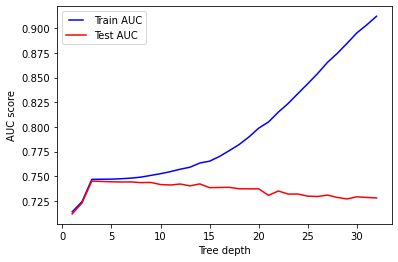

In [89]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show();

In [ ]:
# pipe_params = {
#     'gbc__max_depth':[1, 2, 3, 4],
#     'gbc__learning_rate'  :[0.1, 0.001, 1],
#     'gbc__n_estimators' :[100, 300, 500],
#     'gbc__min_samples_leaf' :[1, 2]
# }


pipe_params = {
    'dt__':[1, 2, 3, 4],
    ''  :[0.1, 0.001, 1],
    '' :[100, 300, 500],
    '' :[1, 2]
}

In [ ]:
X['order_date'] = X['order_date'].map(dt.datetime.toordinal)